In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
from scipy.special import expit
from scipy.special import logit
from scipy.special import erf
from scipy.optimize import curve_fit
import datetime

In [29]:
ts = pd.read_csv("../combined/regions_ts.csv")

In [30]:
base=np.datetime64('2019-12-31')

ts['Date'] = pd.to_datetime(ts['Date'])

ts['diff']= ts['Date']-base
ts['day'] = ts['diff']/np.timedelta64(1,'D')
ts['day'] = ts['day'].astype(int)

ts = ts.rename(columns={'Total Cases': 'Confirmed'})


In [31]:
print('max day = %d, max date = %s' % (ts.day.max(), ts.Date.max()))

max day = 95, max date = 2020-04-04 00:00:00


In [32]:
# aggregate by date
ts = ts.groupby(['Date', 'day', 'Region']).agg({'Confirmed': np.sum, 'Deaths': np.sum, 'Recovered': np.sum}).reset_index().sort_values(by=['day'])
tsAll = ts.groupby(['Date', 'day']).agg({'Confirmed': np.sum, 'Deaths': np.sum, 'Recovered': np.sum}).reset_index().sort_values(by=['day'])


In [33]:
def sigmoid(x, x0, yM, xf):
    y = expit((x-x0)*xf)*yM   # logistic
    #y1 = np.arctan((x-x0)*xf)/np.pi*yM + yM/2 # arctan
    #y2 = np.tanh((x-x0)*xf2)*yM/2 + yM/2 # tanh
    #y3 = erf((x-x0)*xf3)*yM/2 + yM/2 # erf
    return y

def startP0(x,y):
    return [(x.max()+x.min())/2, y.max(), 1]


In [34]:
def regionData(region, metric='Confirmed'):
    if region!=None:
        cdata = ts[(ts['Region']==region)]
    else:
        cdata = tsAll
    x = cdata.day.values
    y = cdata[metric].values
    return x,y

In [35]:
def estimate(region, metric='Confirmed'):
    x,y=regionData(region, metric)

    try:
        p0 = startP0(x,y)
        popt, pcov = curve_fit(sigmoid, x, y, p0=p0)
        perr = np.sqrt(np.diag(pcov))
    except:
        popt = np.array([np.nan,np.nan,np.nan])
        perr = popt

    return popt, perr


In [36]:
estimate('Lombardia')

(array([8.19579999e+01, 5.32383870e+04, 1.70082278e-01]),
 array([1.76352591e-01, 5.74380374e+02, 2.85710300e-03]))

In [37]:
def fitPlot(region, name=None, metric='Confirmed'):
    x,y=regionData(region, metric)

    if name==None:
        name=str(region)

    plt.figure(1, figsize=(8, 6))
    plt.clf()
    plt.title('Sigmoid fit for '+metric+' in '+name)

    ymax=max(y)

    try:
        p0 = startP0(x,y)
        popt, pcov = curve_fit(sigmoid, x, y, p0=p0)
        perr = np.sqrt(np.diag(pcov))

        x_reg = np.linspace(min(x), 2 * max(x) - min(x), 100)
        y_reg = sigmoid(x_reg, *popt)
        y_low = sigmoid(x_reg, popt[0]+perr[0], popt[1]-perr[1]*2, *(popt[2:]+perr[2:]))
        y_high= sigmoid(x_reg, popt[0]-perr[0], popt[1]+perr[1]*2, *(popt[2:]-perr[2:]))

        plt.plot(x_reg, y_reg, linewidth=3.0, label='fit (%.1fk)'%(popt[1]/1000))
        plt.fill_between(x_reg, y_low, y_high, alpha=0.5, label='95% conf')
        ymax = max(ymax, max(y_reg), min(max(y_high), max(y_reg)*2))
    except Exception as e:
        print('Error during fit for %s: %s' % (name, str(e)))
        
    plt.plot(x, y, 'o', label='data')

    plt.ylim(-10, ymax*1.1)
    plt.legend(loc='upper left')
    plt.show()


In [38]:
def estPlot(region, name=None, metric='Confirmed'):
    if name==None:
        name=str(region)

    yMFit = pd.DataFrame()

    x,y=regionData(region, metric)

    for n in range(1,len(x)):
        try:
            sx = x[:n]
            sy = y[:n]
            p0 = startP0(sx,sy)
            popt, pcov = curve_fit(sigmoid, sx, sy, p0=p0)
            perr = np.sqrt(np.diag(pcov))
            err = perr[1]
            yM = popt[1]
        except:
            #print('No fit for day ',n)
            yM = np.nan
            err = np.nan
        yMFit = yMFit.append({'d':x[n], 'est':yM, 'error': err, 'cases': y[n]}, ignore_index=True)

    plt.figure(1, figsize=(8, 6))
    plt.clf()
    plt.title('Estimation over time for '+metric+' in '+name)

    plt.plot(yMFit.d, yMFit.est, linewidth=2.0, label='est')
    yLow=yMFit.est-yMFit.error*2
    yHigh=yMFit.est+yMFit.error*2
    plt.fill_between(yMFit.d, yLow, yHigh, alpha=0.5, label='95% conf')
    plt.plot(x, y, 'o', label='cases')

    plt.ylim(-10, min(yMFit.cases.max()*3, max(yMFit.cases.max(),yMFit.est.max()*1.4)))
    plt.xlim(yMFit.d.min()-2, yMFit.d.max()+2)
    plt.legend(loc='upper left')
    
    plt.show()


In [39]:
def allPlots(region, name=None):
    fitPlot(region,name)
    fitPlot(region,name,'Deaths')
    estPlot(region,name)
    estPlot(region,name,'Deaths')


In [40]:
cRef,cRefErr = estimate('Lombardia')

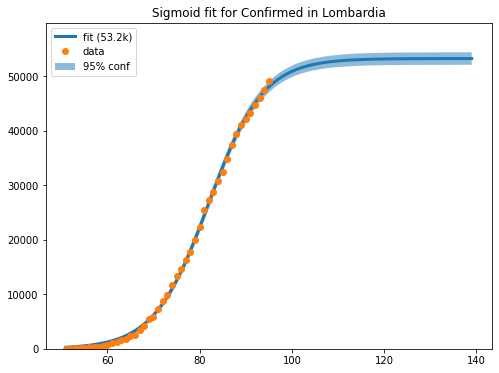

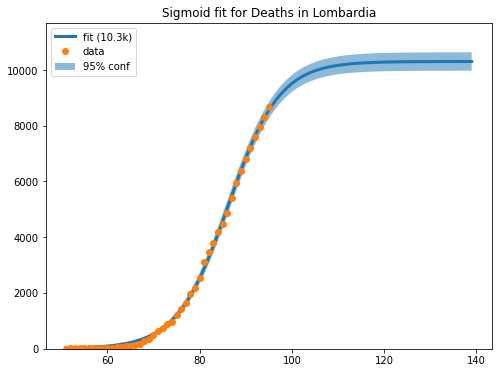

/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


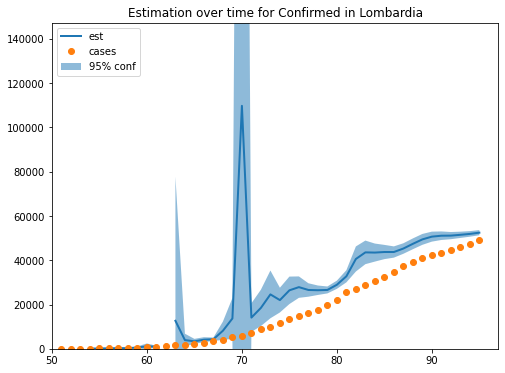

/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


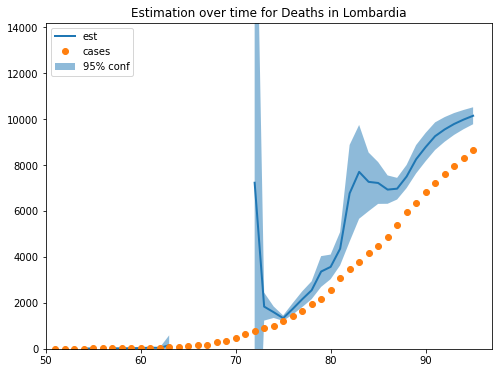

In [41]:
allPlots('Lombardia')

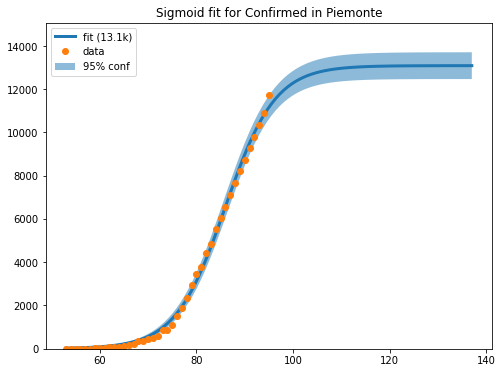

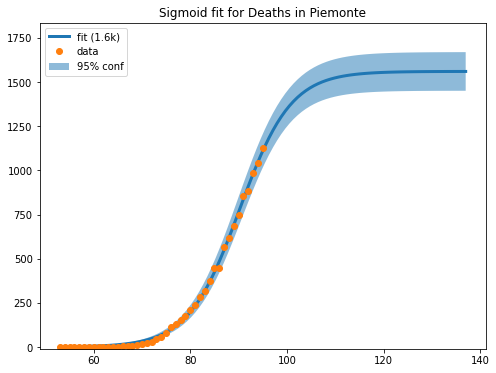

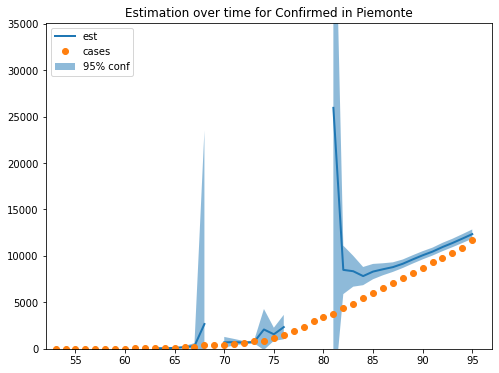

/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


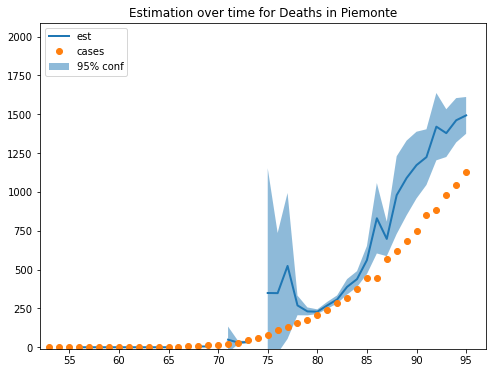

In [42]:
allPlots('Piemonte')

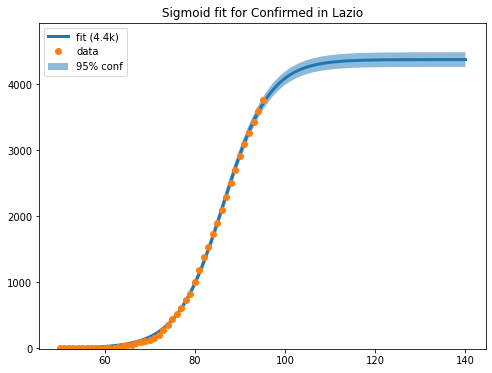

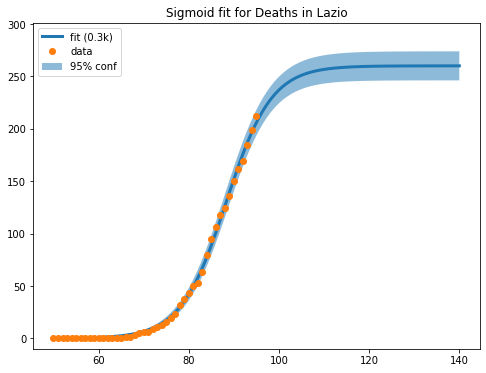

/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app


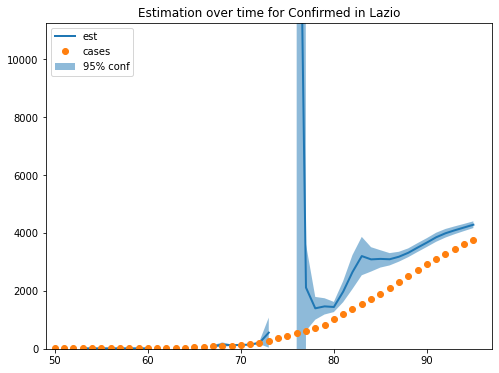

/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


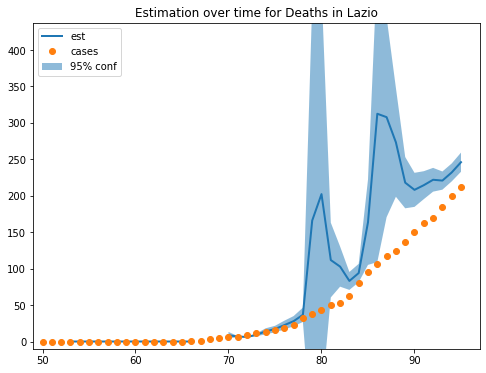

In [43]:
allPlots('Lazio')

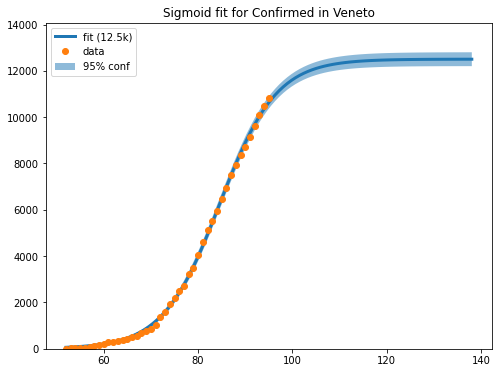

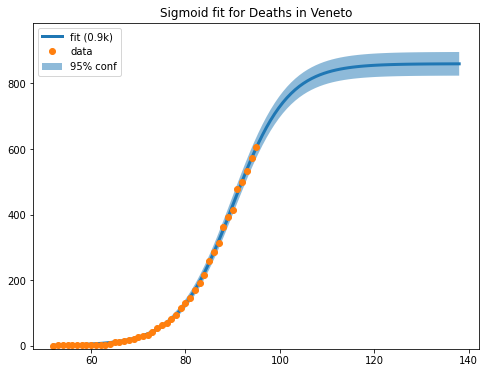

/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


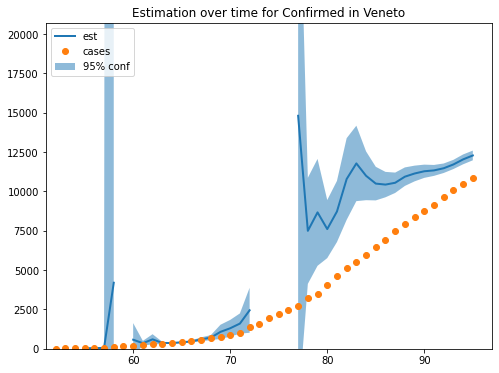

/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


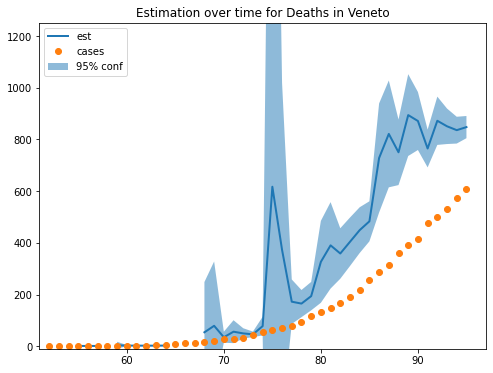

In [44]:
allPlots('Veneto')

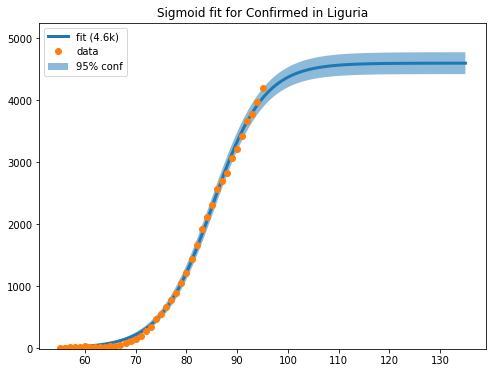

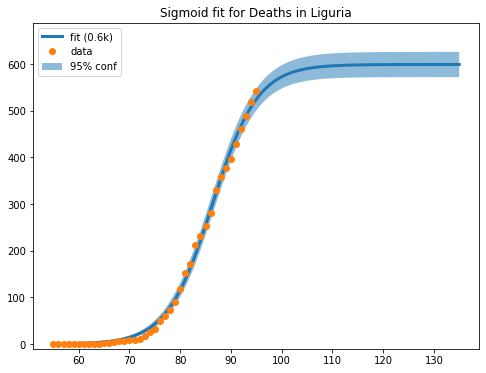

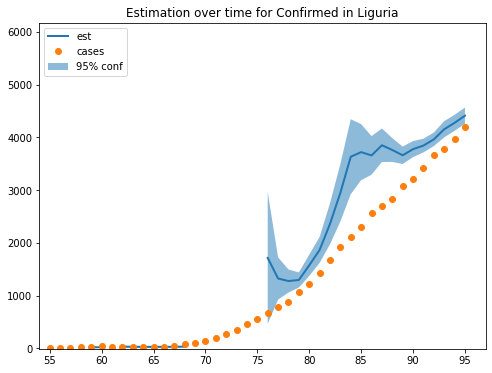

/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


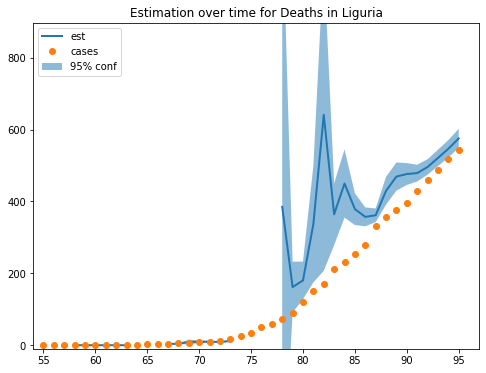

In [45]:
allPlots('Liguria')

In [46]:
regions = ts['Region'].unique()
regions

array(['Lazio', 'Lombardia', 'Veneto', 'Emilia-Romagna', 'Piemonte',
       'P.A. Bolzano', "Valle d'Aosta", 'Umbria', 'Toscana', 'Sicilia',
       'Sardegna', 'Puglia', 'P.A. Trento', 'Marche', 'Molise',
       'Basilicata', 'Calabria', 'Campania', 'Abruzzo',
       'Friuli Venezia Giulia', 'Liguria'], dtype=object)

In [47]:
def plotRegions(regions, metric='Confirmed'):
    try:
        plt.figure(1, figsize=(8, 6))
        plt.clf()
        plt.title('Compare regions with offset')

        for c in regions:
            try:
                pcov, perr = estimate(c)
                delay=int(pcov[0]-cRef[0])
                yM=pcov[1]
                x,y=regionData(c, metric)
                plt.plot(x-int(pcov[0]), y/yM, linewidth=2.0, label= "%s (%d days, max %.1fk)" % (c, delay, yM/1000)) 
            except:
                print('No fit for '+metric+' in '+c)

        plt.ylim(-0.1, 1.1)
        plt.legend(loc='upper left')
        plt.show()
    except:
        print('No fit for '+metric+' in '+c)

No fit for Confirmed in Emilia Romagna


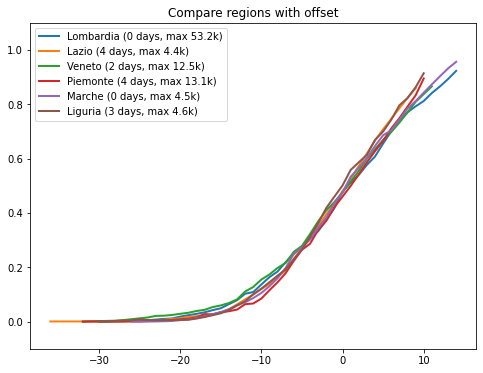

In [48]:
plotRegions(['Lombardia','Lazio','Veneto','Emilia Romagna','Piemonte','Marche','Liguria'])

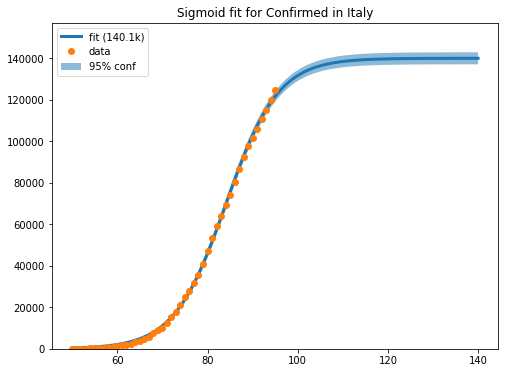

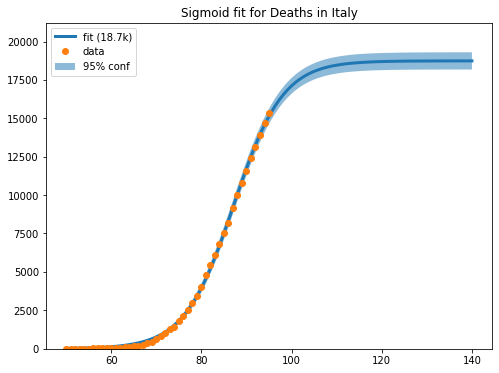

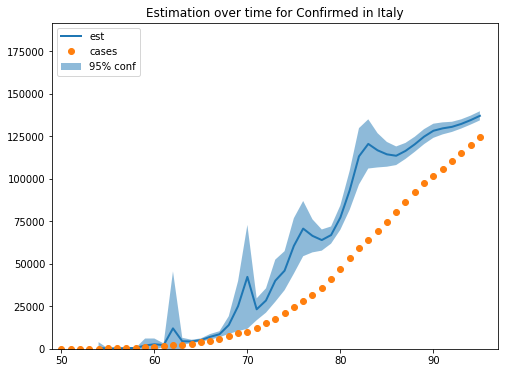

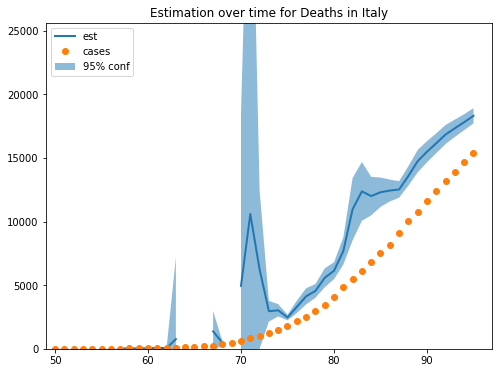

In [49]:
allPlots(None,'Italy')

In [50]:
def forecastTol(region, tolerance=0.99, metric='Confirmed'):
    pcov, perr = estimate(region, metric)

    x0, L, k = pcov
    x0m, Lm, km = (pcov-perr*2)
    x0M, LM, kM = (pcov+perr*2)

    x =  logit(tolerance) / k + x0
    xm = logit(tolerance) / kM + x0m
    xM = logit(tolerance) / km + x0M

    #print (xm, xM)
    #print("%.1f%% of %-9s in %-22s: " % (tolerance*100, metric, region), base+np.timedelta64(int(xm),'D'), base+np.timedelta64(int(xM),'D'))
    return {'Region': region,\
            'Metric':  "%.1f%% of %-9s" % (tolerance*100, metric),\
            'From': base+np.timedelta64(int(xm),'D'),\
            'Est': base+np.timedelta64(int(x),'D'),\
            'To': base+np.timedelta64(int(xM),'D')}
    
def forecastCases(region, leftcases=1, metric='Confirmed'):
    pcov, perr = estimate(region, metric)

    x0, L, k = pcov
    x0m, Lm, km = (pcov-perr*2)
    x0M, LM, kM = (pcov+perr*2)

    x = logit((L-leftcases)/L) / k + x0
    xm = logit((Lm-leftcases)/Lm) / kM + x0m
    xM = logit((LM-leftcases)/LM) / km + x0M

    #print (xm, xM)
    #print("%3d %-9s left in %-22s: " % (leftcases, metric, region), base+np.timedelta64(int(xm),'D'), base+np.timedelta64(int(xM),'D'))
    return {'Region': region,\
            'Metric':  "%d %-9s left" % (leftcases, metric),\
            'From': base+np.timedelta64(int(xm),'D'),\
            'Est': base+np.timedelta64(int(x),'D'),\
            'To': base+np.timedelta64(int(xM),'D')}


In [51]:
def allForecasts(region, tolerance=0.99, leftcases=1):
    data = []
    data.append(forecastTol(region, tolerance))
    data.append(forecastTol(region, tolerance,'Deaths'))
    data.append(forecastCases(region, leftcases))
    data.append(forecastCases(region, leftcases,'Deaths'))
    display(pd.DataFrame(data))

In [52]:
allForecasts('Lombardia')

,Region,Metric,From,Est,To
0,Lombardia,99.0% of Confirmed,2020-04-16,2020-04-17,2020-04-19
1,Lombardia,99.0% of Deaths,2020-04-19,2020-04-20,2020-04-22
2,Lombardia,1 Confirmed left,2020-05-22,2020-05-24,2020-05-27
3,Lombardia,1 Deaths left,2020-05-13,2020-05-16,2020-05-18


In [53]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

data = [forecastTol(r, 0.99) for r in regions]
display(pd.DataFrame(data).sort_values(by=['Est'],ascending=False))
print()


,Region,Metric,From,Est,To
17,Campania,99.0% of Confirmed,2020-04-27,2020-05-01,2020-05-05
14,Molise,99.0% of Confirmed,2020-04-24,2020-04-30,2020-05-07
2,Veneto,99.0% of Confirmed,2020-04-19,2020-04-21,2020-04-22
8,Toscana,99.0% of Confirmed,2020-04-18,2020-04-20,2020-04-22
11,Puglia,99.0% of Confirmed,2020-04-17,2020-04-19,2020-04-20
3,Emilia-Romagna,99.0% of Confirmed,2020-04-18,2020-04-19,2020-04-20
0,Lazio,99.0% of Confirmed,2020-04-17,2020-04-18,2020-04-19
4,Piemonte,99.0% of Confirmed,2020-04-16,2020-04-18,2020-04-20
19,Friuli Venezia Giulia,99.0% of Confirmed,2020-04-16,2020-04-18,2020-04-21
12,P.A. Trento,99.0% of Confirmed,2020-04-14,2020-04-17,2020-04-20


In [54]:
data = [forecastCases(r, 1) for r in regions]
display(pd.DataFrame(data).sort_values(by=['Est'],ascending=False))
print()

,Region,Metric,From,Est,To
17,Campania,1 Confirmed left,2020-05-20,2020-05-26,2020-06-01
1,Lombardia,1 Confirmed left,2020-05-22,2020-05-24,2020-05-27
2,Veneto,1 Confirmed left,2020-05-18,2020-05-20,2020-05-22
3,Emilia-Romagna,1 Confirmed left,2020-05-18,2020-05-19,2020-05-21
8,Toscana,1 Confirmed left,2020-05-10,2020-05-13,2020-05-17
4,Piemonte,1 Confirmed left,2020-05-10,2020-05-13,2020-05-17
0,Lazio,1 Confirmed left,2020-05-06,2020-05-08,2020-05-10
14,Molise,1 Confirmed left,2020-04-30,2020-05-08,2020-05-17
20,Liguria,1 Confirmed left,2020-05-03,2020-05-06,2020-05-09
11,Puglia,1 Confirmed left,2020-05-03,2020-05-05,2020-05-08
